In [3]:
import fitz
import requests
import io
import pickle
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re
from bs4 import BeautifulSoup
import pandas as pd
import nltk

In [22]:
doc = fitz.open("../data/test_pdf+xml/Trevisanus1567_De_alchemia_MDZ_MBS.pdf")

In [23]:
doc.page_count

24

In [31]:
p = doc.load_page(14)

In [32]:
p

page 14 of ../data/test_pdf+xml/Trevisanus1567_De_alchemia_MDZ_MBS.pdf

In [33]:
pix = p.get_pixmap()

In [34]:
pix.width

1159

In [35]:
pix.height

1740

In [36]:
np_array = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n) # if you need an image matrix...

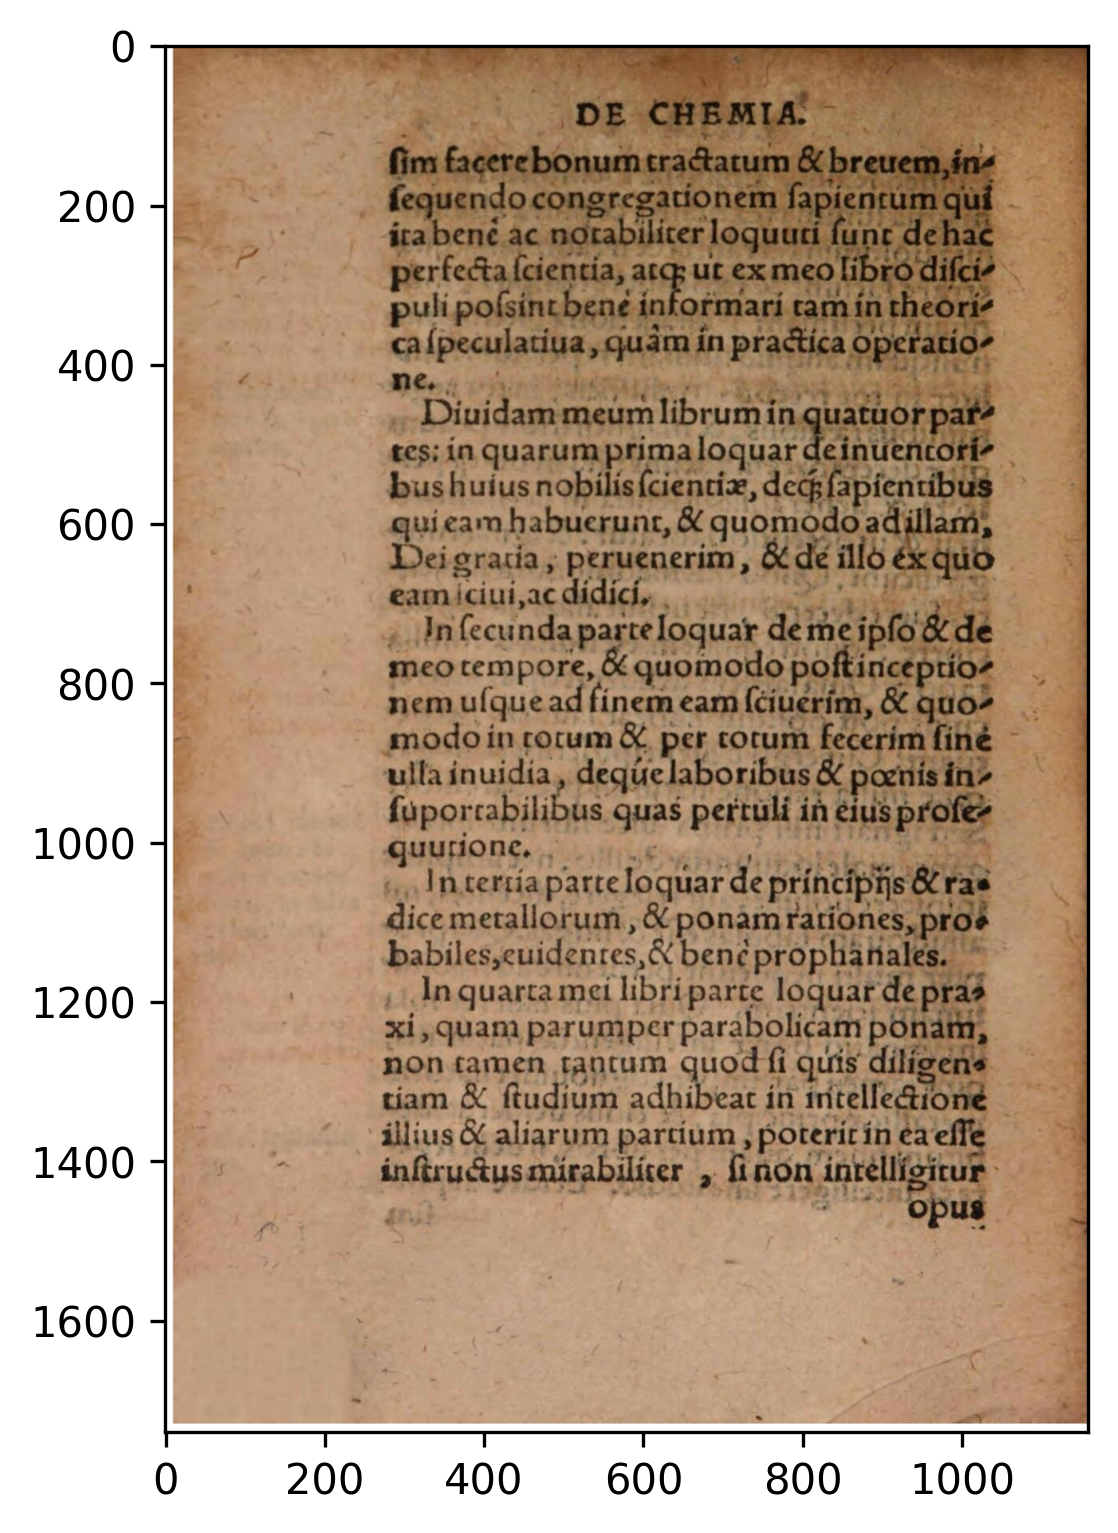

In [37]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
ax.imshow(np_array)

In [38]:
print(p.get_text())

DE CHEMIA.
sim facere bonum tractatum & breuem, in¬
sequendo congregationem sapientum qui
ita benè ac notabiliter loquuti sunt de hac
perfecta scientia, atque ut ex meo libro disci¬
puli possint benè informari tam in theori¬
ca speculatiua, quàm in practica operatio¬
ne.
Diuidam meum librum in quatuor par¬
tes: in quarum prima loquar de inuentori¬
bus huius nobilis scientiae, deque sapientibus
qui eam habuerunt, & quomodo adillam,
Dei gratia, peruenerim, & de illo ex quo
eam sciui, ac didici.
In secunda parte loquar de me ipso & de
meo tempore, & quomodo post inceptio¬
nem usque ad finem eam sciuerim, & quo¬
modo in totum & per totum fecerim sinè
ulla inuidia, deque laboribus & poenis in¬
suportabilibus quas pertuli in eius prose¬
quutionę.
In tertia parte loquar de principijs & ra¬
dice metallorum, & ponam rationes, pro¬
babiles, euidentes, & bene prophanales.
In quarta mei libri parte loquar de pra¬
xi, quam parumper parabolicam ponam
non tamen tantum quod si quis diligen¬
tiam & stu

Zde je potřeba zachytit, kde začíná a končí jeden text a začíná následující.

In [39]:
textblocks = p.get_text_blocks() # ("blocks")
textblocks

[(500.3999938964844,
  93.60006713867188,
  808.707275390625,
  98.40006256103516,
  'DE CHEMIA.\n',
  0,
  0),
 (280.32000732421875,
  152.90396118164062,
  1046.18701171875,
  157.82395935058594,
  'sim facere bonum tractatum & breuem, in¬\n',
  1,
  0),
 (270.7200012207031,
  198.72006225585938,
  1049.1983642578125,
  203.5200653076172,
  'sequendo congregationem sapientum qui\n',
  2,
  0),
 (272.6400146484375,
  245.30398559570312,
  1038.970458984375,
  250.22398376464844,
  'ita benè ac notabiliter loquuti sunt de hac\n',
  3,
  0),
 (272.6400146484375,
  288.4800720214844,
  1042.28466796875,
  293.2800598144531,
  'perfecta scientia, atque ut ex meo libro disci¬\n',
  4,
  0),
 (278.3999938964844,
  333.6000671386719,
  1047.999755859375,
  338.4000549316406,
  'puli possint benè informari tam in theori¬\n',
  5,
  0),
 (269.760009765625,
  379.6800231933594,
  1051.14892578125,
  384.4800109863281,
  'ca speculatiua, quàm in practica operatio¬\n',
  6,
  0),
 (271.6799926757

Geometrie zde vymezuje dva body ohraničující obdelník, v němž se text nachází:

In [19]:
rect = textblocks[2][:4]

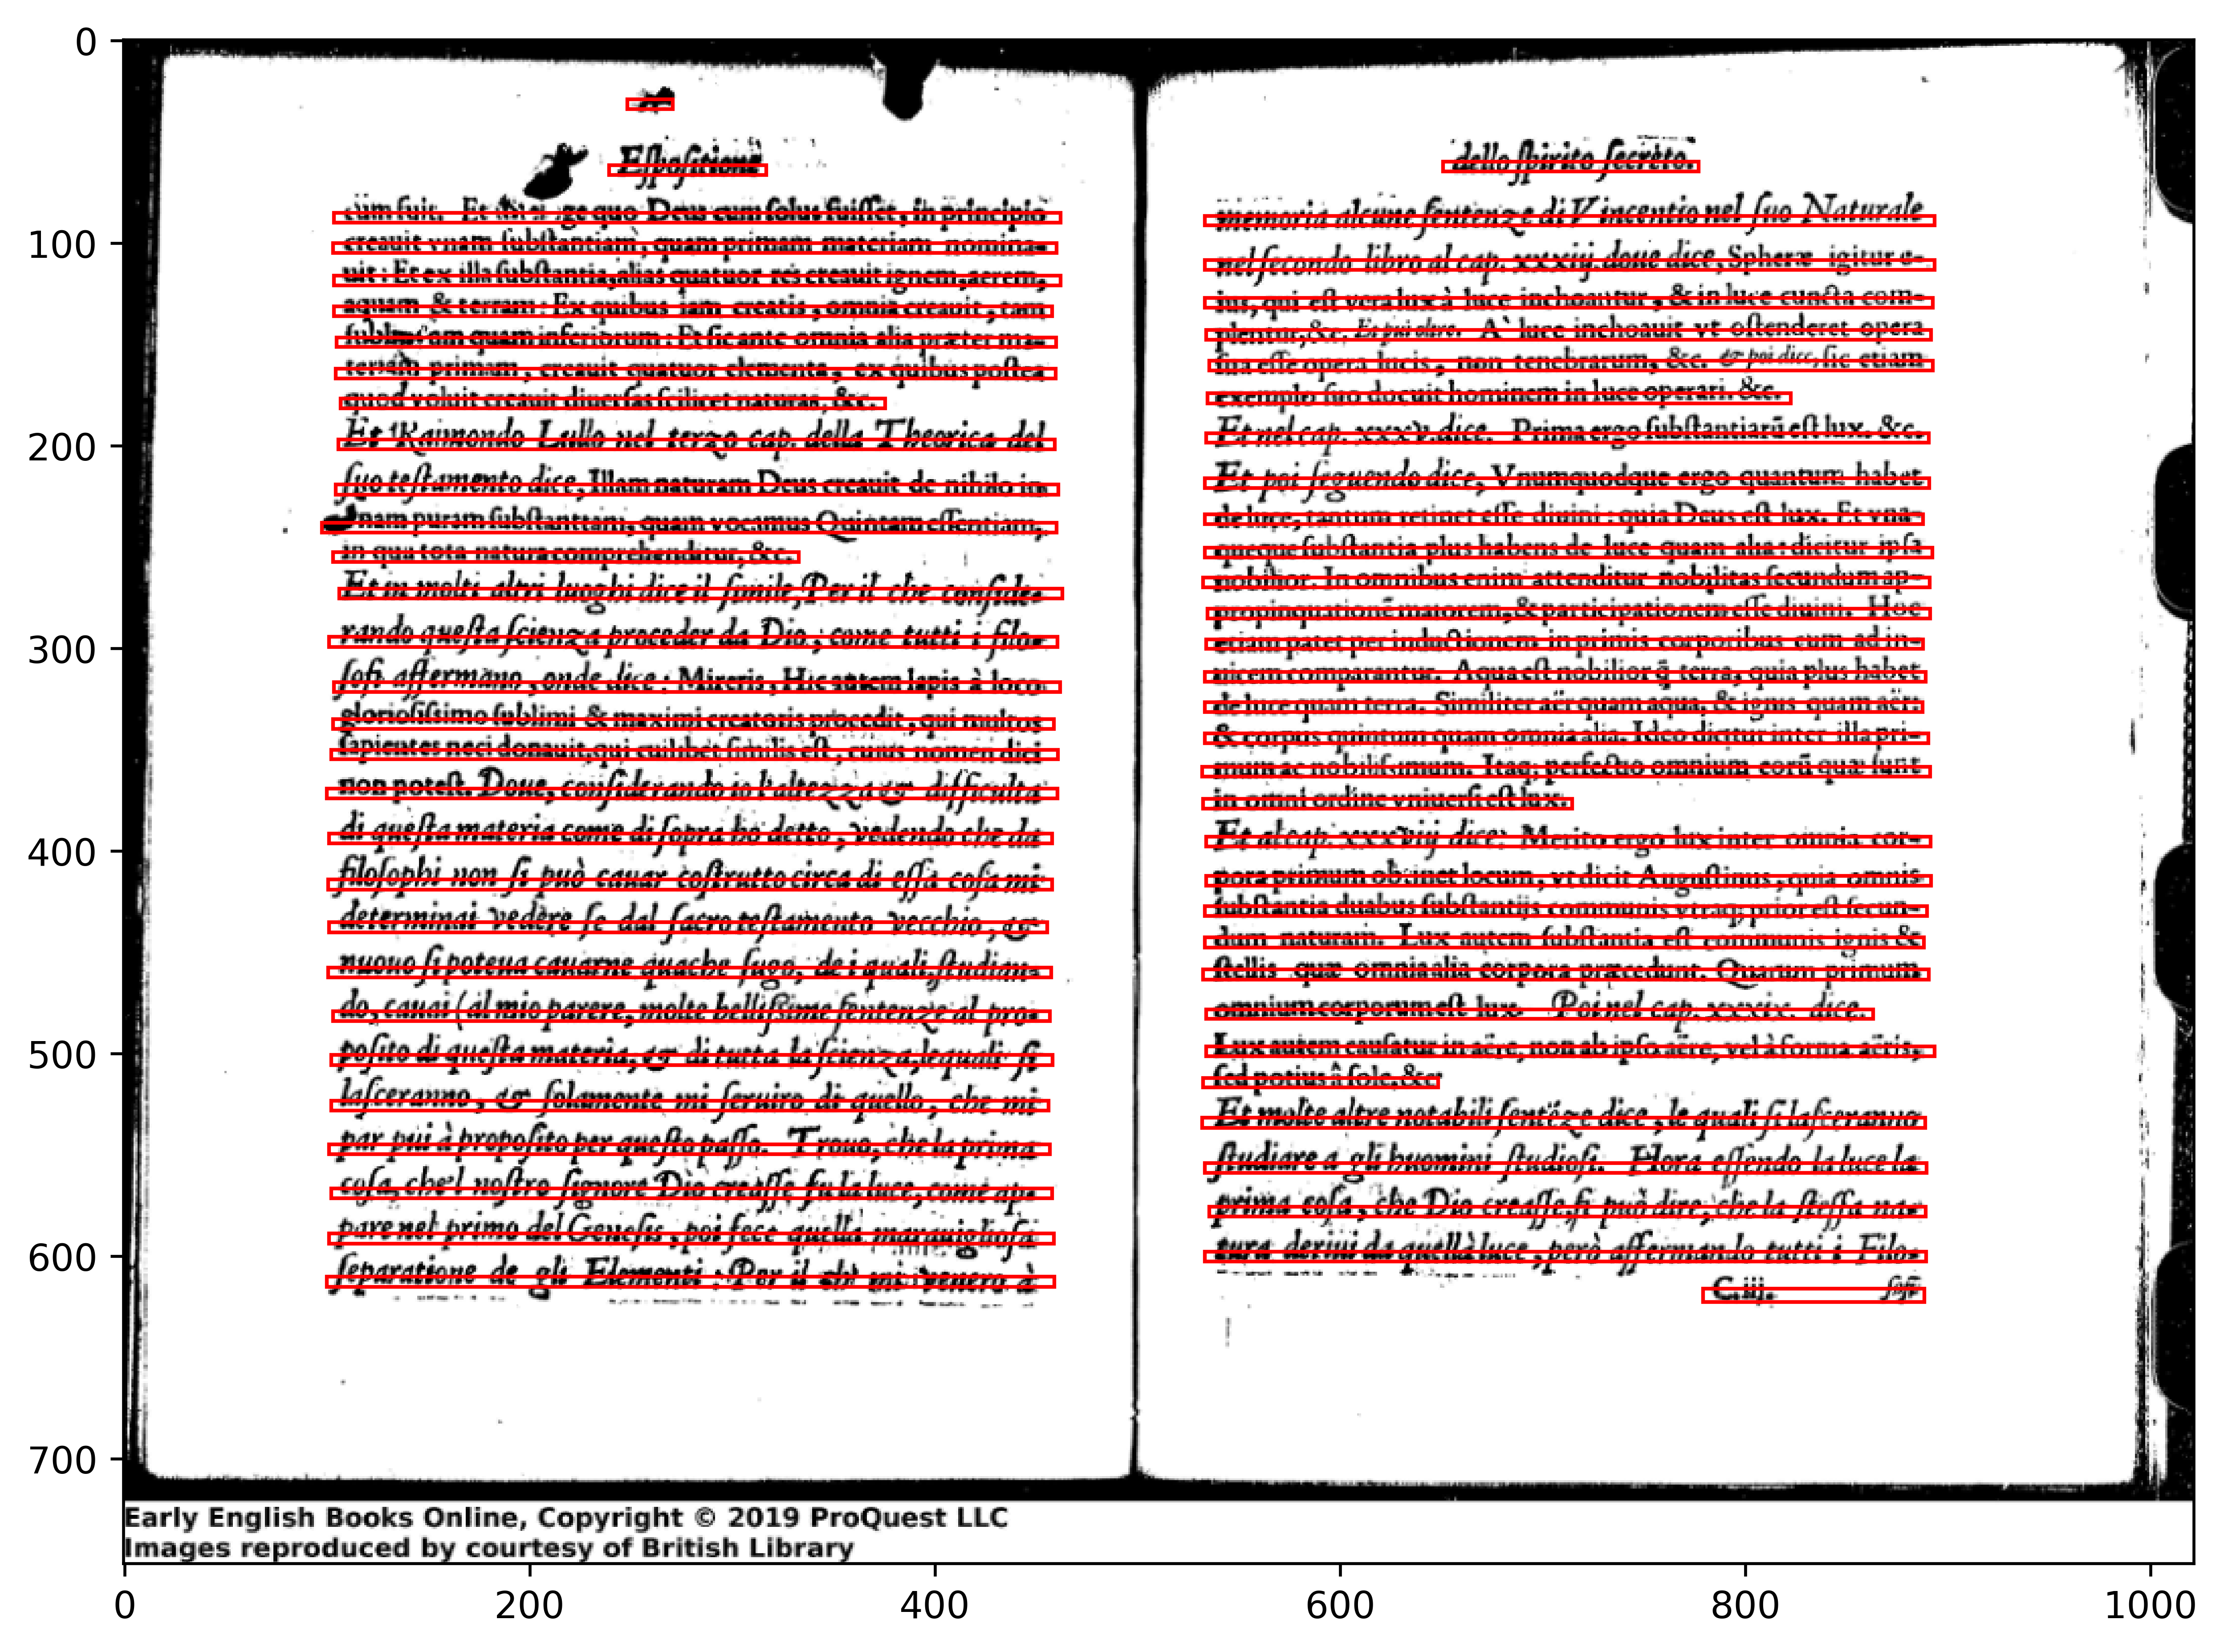

In [21]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=600)

for textblock in textblocks:
    rect = textblock[:4]
    ax.imshow(np_array)
    patch = patches.Rectangle((rect[0], rect[1]),  # Bottom left corner
                          rect[2] - rect[0],  # Width
                          rect[3] - rect[1],  # Height
                          linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

Mít povědomí o těchto strukturálních vlastnostech PDF dokumentů je velice důležité, když z těchto dokumentů chceme získat strojově čitelný text pro další textové analýzy. PDF dokumenty jsou například často opatřeny záhlavím či zápatím, kde se objevuje třeba číslo stránky, jako je tomu zde, jindy je zde název periodika, jméno autora, jméno příspěvku apod. Vyextrahujeme-li ze všech stránek v daném dokumentu syrový text pomocí p.get_text(), budeme v našem textu mít i řetězce znaků z těchto textových bloků, což není žádoucí. Buď se tomu pokusíme předejít již při samotné extrakci, kdy můžeme využít geometrické polohy jednotlivých text bloků,  nebo se těchto dat pokusíme zbavit během následného čištění, např. pomocí *regulérních výrazů* (viz příslušná kapitola). Který případ je vhodnější závisí případ od případu a vyžaduje testování. Zde se budeme držet druhého případu.

In [ ]:
text = ""
for p in doc:
    text += p.get_text()

In [ ]:
text[10000:12000]

In [ ]:
print(text[10000:12000])

Na text aplikujeme několik čistících funkcí.

In [ ]:
test = "neboť v tomto času se do- pracoval k formulací své otázky"
test = re.sub("(?<=[a-zA-Z])-[\n|\s]", "", test)
test

In [ ]:
text = re.sub("\n\s?\d{1,3}\s?\n", "\n", text)
text = re.sub("\xad\n", "", text)
text = re.sub(r"(?<=\w)-[\n|\s]", "", text)
text = re.sub("\s\s+", " ", text.replace("\n", " "))
text[10000:12000]

Výsledek zdaleka není perfektní. V textu stále vidíme řadu problémů. Některé souvisejí s formátováním, jiné jsou dědictvím OCR analýzy. Pro naše aktuální potřeby však text v této podobě postačuje. 


### Aplikace NLP na získaný text

In [ ]:
chunks = re.findall(r'.{0,50000}\.\s', text, re.DOTALL)
chunks_end = sum([len(chunk) for chunk in chunks])
chunks.append(text[chunks_end:])
docs = [czech_pipeline(chunk) for chunk in chunks]

In [ ]:
[len(chunk) for chunk in chunks]

In [ ]:
lemmatized_sents = []
for doc in docs:
    for sent in doc.sentences:
        lemmatized_sents.append([t.lemma for t in sent.words if t.upos in ["PROPN", "NOUN", "VERB", "ADJ"]])

In [ ]:
lemmatized_sents[100:110]

In [ ]:
kontrola_pruchodu(ntb="pdf", arg1=lemmatized_sents[50])

> **Zde končí povinná část cvičení.** 

## Rozšiřující analýza 1: Extrakce textu ze všech čísel periodika

Nyní postoupíme dále a aplikujeme tento přístup na vyextrahování textu ze všech čísel daného periodika: https://scriptum.cz/cs/periodika/studie.

Použijeme obdobný postup, jaký jsme použili v kapitole o webscrapingu. Nejprve si vyextrahujeme seznam jmen všech relevantních souborů (zajímají nás pouze souboru, které končí "ocr.pdf" - i zde se nám hodí regex).

Tyto funkce jsou však již výpočetně poměrně náročné, tudíž tuto sekci je možné přeskočit.

In [ ]:
resp = requests.get("https://scriptum.cz/cs/periodika/studie")
soup = BeautifulSoup(resp.content)
hrefs = [a.get('href') for a in soup.find_all("a")]
hrefs = [href for href in hrefs if re.search("ocr\.pdf$", href)]
hrefs = [href for href in hrefs if not ("rejstrik" in href or "obsah" in href)]
hrefs[:20]

In [ ]:
len(hrefs)

Nyní si vytvoříme funkci, do které vnoříme všechny extrakční, transformační a čistící procedury, které jsme prošli výše.  

In [ ]:
def get_cleaned_text(url):
    try:
        filename = url.rpartition("/")[2]
        pdf_object = io.BytesIO(requests.get(url).content)
        doc = fitz.open("pdf", pdf_object.read())
        text = ""
        for p in doc:
            text += p.get_text()
        pattern = "(_+)?(\n?Studie[\s_]+\d{4}\n?)(\W*\w{0,3}\s*/\s*\d\n?)?"
        text = re.sub(pattern, "\n", text)
        text = re.sub("\n\s?\d{1,3}\s?\n", "\n", text)
        text = re.sub("\xad\n", "", text)
        text = re.sub("\s\s+", " ", text.replace("\n", " "))
        text = text.replace("- \n", "")
        year = int(re.search("\d{4}", filename).group())
        return filename, year, text
    except:
        pass

A následně tuto funkci aplikujeme jeden po druhém na všechny dostupné soubory pomocí cyklu FOR. Máme před sebou více než 100 jmen souborů, tj. vzneseme více než 100 HTTP dotazů. Tudíž provedení kódu zabere nějaký čas.

In [ ]:
%%time
scriptum_data = []
for filename in hrefs:
    filename, year, text = get_cleaned_text(filename)
    scriptum_data.append({"filename" : filename, "year" : year, "text" : text})

Vyextrahovaná data si převedeme do objektu typu `pandas.DataFrame` 

In [ ]:
scriptum_df = pd.DataFrame(scriptum_data)
scriptum_df.head(10)

Spočteme počet znaků v každém z námi vyextrahovaných textů a vytvoříme nový sloupec "n_chars", kam tuto hodnotu uložíme.

In [ ]:
scriptum_df["n_chars"] = scriptum_df["text"].str.len()
scriptum_df.head(5)

Díky tomu můžeme sečíst celkový počet znaků všech textů z daného periodika.

In [ ]:
scriptum_df["n_chars"].sum()

Tímto se nám tedy dostal do rukou další nemalý dataset zajímavých kulturních dat. Pokud pracujeme s repozitoří "pribehy-dat" jako celkem, dataset si uložíme do podsložky data:  

In [ ]:
#scriptum_df.to_json("scriptum_df.json")

## Rozšiřující analýza 2: Zpracování textových dat

Nyní trochu přeskočíme k tématu, kterým se budeme zabývat samostatně v jedné z jiných kapitol: kvantitativní textová analýza. Následující sérii kroků proto si proto v tuto chvíli nebudeme podrobně vysvětlovat, zaměříme se až na výsledná data.

Budeme k nim potřebovat knihovnu stanza a model pro předzpracování textových dat v češtině.

In [ ]:
#scriptum_df = pd.read_json("scriptum_df.json")

Pro testovací účely si vybereme jeden text z jednoho čísla:

In [ ]:
text = scriptum_df["text"].tolist()[0]
text[2000:3000]

Na celý dokument aplikujeme jazykový model pro předzpracování, který text automaticky:
* rozdělí do vět
* věty do slov
* jednotlivým slovům přiřadí *lemmata*, tj. převede je do tvarů, jak je najdeme ve slovníku (např. "je" -> "být").
* přiřadí jim "part-of-speech" (POS) tagy (např. "NOUN", "VERB" apod. "PUNCT" apod.)

In [ ]:
len(text)

In [ ]:
%%time
doc = czech_pipeline(text)

Vytvořili jsme nový `stanza` objekt `doc`, který obsahuje podrobně jazykově anotovanou reprezentaci celého textu. Z této reprezentace si nyní vyjmeme pouze lemmata vybraných slovních druhů: 

In [ ]:
lemmatized_sents = []
for sent in doc.sentences:
    lemmatized_sents.append([t.lemma for t in sent.words if t.upos in ["PROPN", "NOUN", "VERB", "ADJ"]])
print(lemmatized_sents[100:110])

Ani v tomto případě nejsou výsledky ani zdaleka perfektní. Vše se odvíjí zejména z kvality vstupních dat. Vidíme např., že model si nedokáže poradit se slovy, které jsou ve stupních datech zachycena v rozdělené podobě apod. I přesto nyní postoupíme dále a aplikujeme danou proceduru na texty všech čísel. 

Opět si pro tento účel nadefinujeme speciální funkci.

In [ ]:
processed = []
!mkdir data
!mkdir data/large_files
!mkdir data/large_files/lemsents
def get_lemmatized_sentences(filename, text, n_chars):
    if filename not in ["studie_1990_132_ocr.pdf"]:
        if filename + ".pickle" not in os.listdir("../data/large_files/lemsents/"):
            chunks = re.findall(r'.{0,50000}\.\s', text, re.DOTALL)
            chunks_end = sum([len(chunk) for chunk in chunks])
            chunks.append(text[chunks_end:])
            docs = [czech_pipeline(chunk) for chunk in chunks]
            lemmatized_sents = []
            for doc in docs:
                for sent in doc.sentences:
                    lemmatized_sents.append([t.lemma for t in sent.words if t.upos in ["PROPN", "NOUN", "VERB", "ADJ"]])
            processed.append(filename)
            pathfn = "data/large_files/lemsents/" + filename + ".pickle"
            with open(pathfn, 'wb') as f:
                pickle.dump(lemmatized_sents, f)
            print(filename, n_chars, len(processed))
        else:
            pathfn = "data/large_files/lemsents/" + filename + ".pickle"
            with open(pathfn, 'rb') as f:
                lemmatized_sents = pickle.load(f)
    else:
        lemmatized_sents = None
    return lemmatized_sents

Aplikace této funkce na všechny dokumenty v seznamu však zabere značný čas. Abychom se vyhnuli čekání, načteme si proto data, v kterých jsem již tuto proceduru aplikoval dříve (jak jsem to provedl je vidět v zakomentovaných příkazech v buňce níže.

### Nejčastější slova po obdobích

In [ ]:
%%time
#scriptum_df["lemmatized_sents"] = scriptum_df.apply(lambda row: get_lemmatized_sentences(row["filename"], row["text"], row["n_chars"]), axis=1)
# scriptum_df.to_json("../data/scriptum_df_lemmata.json")
scriptum_df = pd.read_json("https://raw.githubusercontent.com/CCS-ZCU/pribehy-dat/master/data/scriptum_df_lemmata.json")
scriptum_df.head(5)

In [ ]:
periods_freqs = {}
periods = [(1958,1968), (1969,1976), (1977,1990)]
periods_labels = ["Studie {0}-{1}".format(str(period[0]), str(period[1])) for period in periods]
for period, period_label in zip(periods, periods_labels):
    subset_df = scriptum_df[scriptum_df["year"].between(period[0], period[1])]
    lemmatized_sents = [sentences for sentences in subset_df["lemmatized_sents"] if sentences != None]
    sentences_flat = [sent for file_sents in lemmatized_sents for sent in file_sents]
    lemmata_list = [lemma for sent in sentences_flat for lemma in sent]
    lemmata_list = [lemma for lemma in lemmata_list if len(lemma) > 1]
    lemmata_freqs = nltk.FreqDist(lemmata_list).most_common()
    periods_freqs[period_label] = lemmata_freqs

Podívejme se namátkou na 50 nejčastějších slov z nejranějšího období.

In [ ]:
periods_freqs[periods_labels[0]][:50]

In [ ]:
wc = WordCloud(width=800, height=400).generate_from_frequencies(dict(periods_freqs[periods_labels[0]][:50]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
n = 100
fig, axs = plt.subplots(3,1, figsize=(4.5, 5) , dpi=300, tight_layout=True)
for item, ax in zip(periods_freqs.items(), axs.ravel()):    
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(dict(item[1][:n]))
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(item[0])
    ax.axis("off")

### Lematizované věty s vybranými slovy

Nyní si nadefinujeme funkci, pomocí které budeme moci vyextrahovat veškeré věty obsahující konkrétní slova.

In [ ]:
def extract_target_sents(lemmatized_sents, targets):
    try:
        return [sent for sent in lemmatized_sents if any(target in sent for target in targets)]
    except:
        return []

In [ ]:
my_targets = ["kultura"]
scriptum_df["target_sents"] = scriptum_df["lemmatized_sents"].apply(extract_target_sents, args=(my_targets,))

In [ ]:
scriptum_df["target_sents"].apply(lambda x: len(x) if x != None else 0).sum()

In [ ]:
scriptum_df["target_sents"]

Jaká slova se v těchto větách objevují nejčastěji?

In [ ]:
column_sents = scriptum_df["target_sents"].tolist()
target_sents_counts = nltk.FreqDist([t for sent in [t for sent in column_sents for t in sent] for t in sent]) #
target_sents_counts = target_sents_counts.most_common()
target_sents_counts[:20]

In [ ]:
wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(dict(target_sents_counts[:50]))
plt.imshow(wc) # , interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
column_sents = scriptum_df["target_sents"].tolist()
target_sents_counts = nltk.FreqDist([t for sent in [t for sent in column_sents for t in sent] for t in sent]) #
target_sents_counts = target_sents_counts.most_common()
target_sents_counts[:20]